In [33]:
import sys
sys.path.append("../model/ConvLSTM")
from trainer import Trainer

from config import configs

from utils import ndviDataset
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt

import torch

In [46]:
import datetime

In [57]:
import xarray as xr

In [53]:
import pandas as pd
plt.style.use('seaborn')

In [34]:
def rmse_func(y_pred, y_true, mask):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    mask = torch.from_numpy(mask)
    rmse = torch.sum((y_pred - y_true)**2*mask, dim=[1, 2]) / mask.sum(dim=[1, 2])
    rmse = rmse.sqrt()
    return rmse

In [35]:
input_gap = configs.input_gap
input_length = configs.input_length
pred_shift = configs.pred_shift
output_length = configs.output_length

In [8]:
full_data_path = "/att/nobackup/jli30/workspace/ndvi_MGBrown_notebooks/data/timeseries"
start_idx = 47
end_idx = 76
dataset_test = ndviDataset(full_data_path, start_idx, end_idx,
                            input_gap, input_length, pred_shift, output_length,
                            samples_gap=1)
print(dataset_test.getDataShape())

{'train_masks': (23, 1, 1, 52, 75), 'inputs': (23, 6, 1, 52, 75), 'targets': (23, 1, 1, 52, 75)}


In [9]:
dataloader_test = DataLoader(dataset_test, batch_size=configs.batch_size_test, shuffle=False)

#### load and test model

In [11]:
tester = Trainer(configs)
tester.network.load_state_dict(torch.load('../model/ConvLSTM/checkpoint.chk')['net'])
tester

In [12]:
 rmse, mae, acc, ndvi_pred = tester.infer(dataset_test, dataloader_test)

In [13]:
print(rmse)

0.06980784237384796


In [14]:
print(mae)

0.046700749546289444


In [15]:
print(acc)

0.7075439095497131


#### vis

In [47]:
# construct datestamps
days = range(1, 365, 16)
s = [str(d).zfill(3) for d in days]
date = []
for year in range(2008, 2018):
    d = [str(year)+t for t in s]
    date.extend(d)

dates = [datetime.datetime.strptime(a, '%Y%j') for a in date]

In [61]:
pred = ndvi_pred.cpu().numpy()[:,0,0]
targets = dataset_test.targets[:,0,0]
masks = dataset_test.train_masks[:,0,0]
pred.shape

(23, 52, 75)

In [64]:
#compute rmse
rmse = rmse_func(pred, targets, masks)

<AxesSubplot:xlabel='Date'>

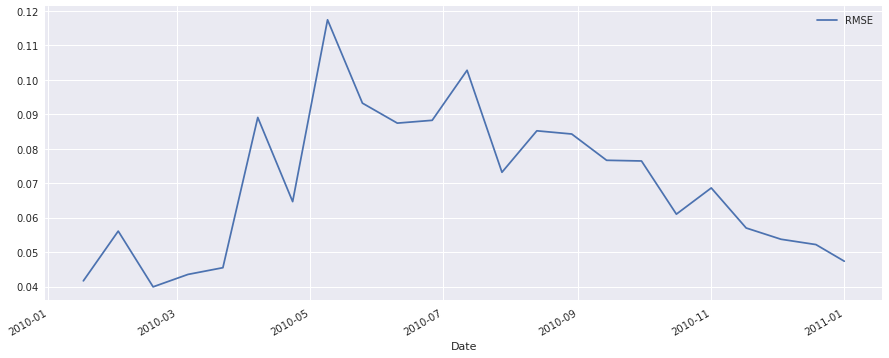

In [65]:
df = pd.DataFrame()
df['Date'] = dates[47:70]
df['RMSE'] = rmse.numpy()
df_p = df.set_index('Date')
df_p.plot(figsize=(15, 6))

In [55]:
from matplotlib.colors import ListedColormap

In [84]:
black = ListedColormap(['Black'])
white = ListedColormap(['White'])
white = np.array(white(0))[None]
black = np.repeat(np.array(black(0))[None], 12, axis=0)
blues = plt.cm.get_cmap('Blues', 60)(np.linspace(0, 1, 60))[::-1]
reds = plt.cm.get_cmap('Reds', 60)(np.linspace(0, 1, 60))
cmap_diff = np.vstack((blues, white, reds))
cmap_diff = ListedColormap(cmap_diff)

In [66]:
diff_convlstm = pred - targets

In [68]:
diff_convlstm.min(), diff_convlstm.max()

(-0.5683, 0.43938053)

Text(0.42, 1.01, 'model = convlstm;  diff=pred-target')

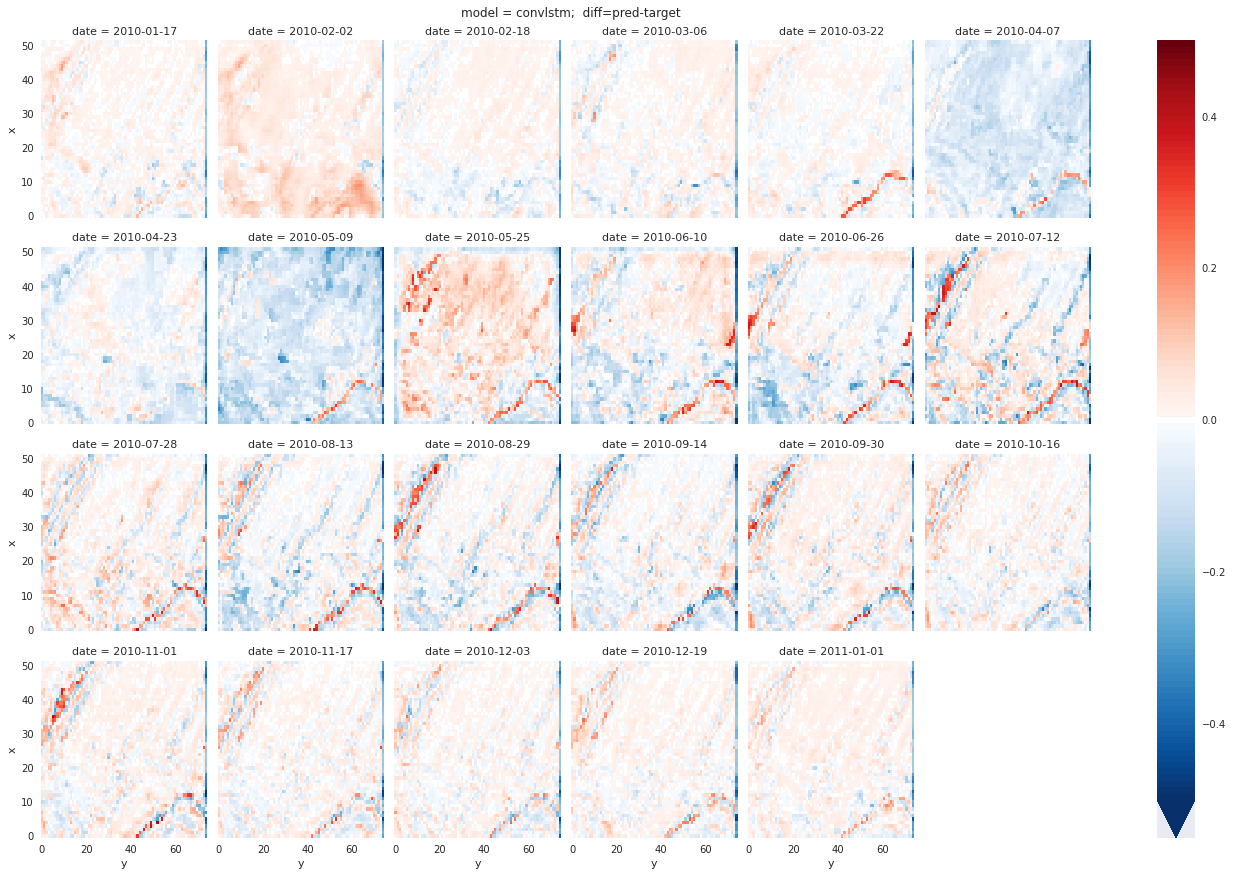

In [87]:
copy = diff_convlstm.copy()
arr = xr.DataArray(copy[:, ::-1], dims=['date', 'x', 'y'], coords={'date': dates[47:70]})
arr.plot(col='date', col_wrap=6, cmap=cmap_diff, vmin=-0.5, vmax=0.5)
plt.suptitle(f'model = convlstm;  diff=pred-target', x=0.42, y=1.01)

In [80]:
# plot the target 
greens = plt.cm.get_cmap('Greens', 120)(np.linspace(-0.2, 1, 120))
cmap = np.vstack(greens)
cmap = ListedColormap(cmap)

Text(0.42, 1.01, 'NDVI targets')

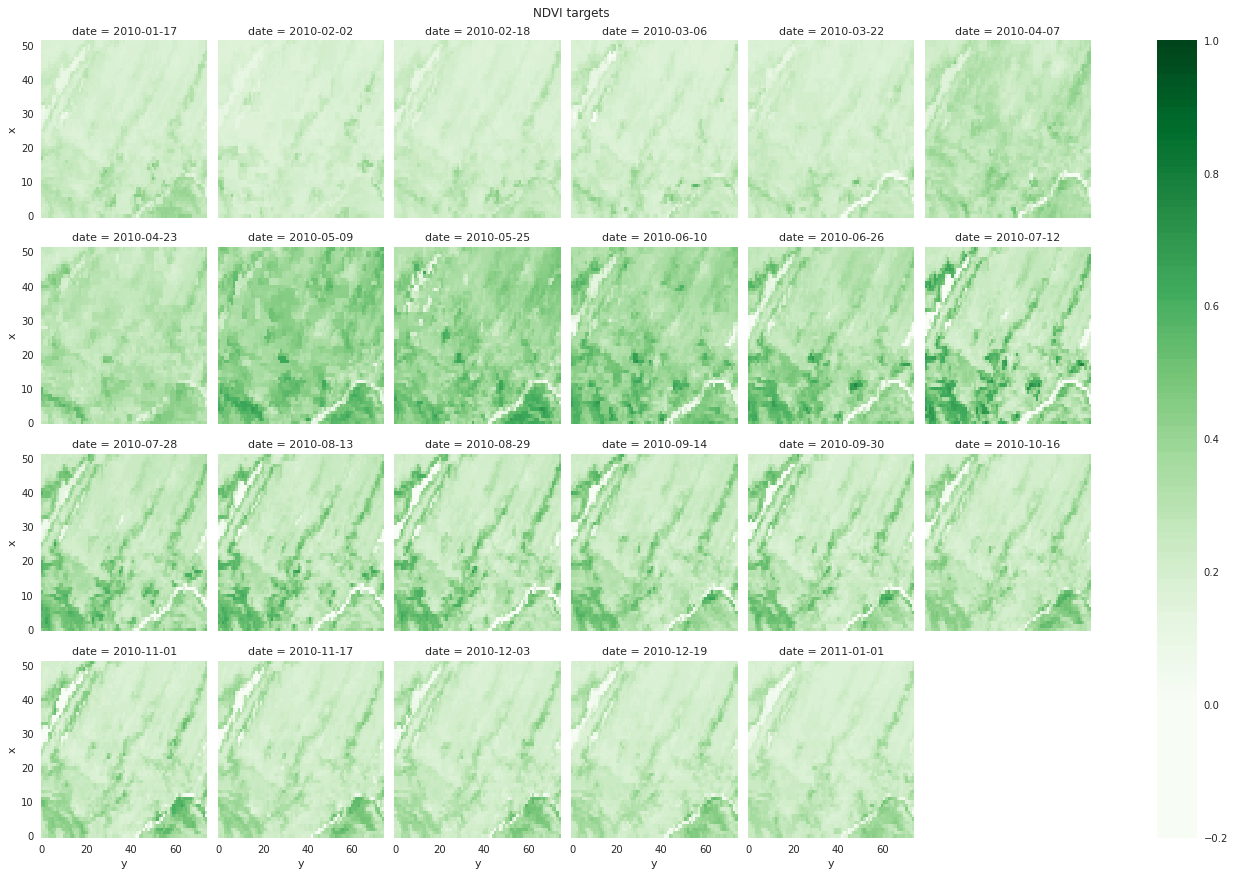

In [86]:
arr = xr.DataArray(targets[:, ::-1], dims=['date', 'x', 'y'], coords={'date': dates[47:70]})
arr.plot(col='date', col_wrap=6, cmap=cmap, vmin=-0.2, vmax=1)
plt.suptitle("NDVI targets", x=0.42, y=1.01)